# vLLM Batched Inference Example

This notebook demonstrates how to use the vLLM server for offline batched inference through the OpenAI-compatible API.

In [1]:
import asyncio
import httpx
import json
import os
from typing import List, Dict, Any
import pandas as pd
from datetime import datetime
import time

In [5]:
# Configuration
VLLM_SERVER_URL = os.getenv('VLLM_SERVER_URL', 'http://vllm-server:8000')
API_KEY = os.getenv("VLLM_API_KEY", None)  # Should match the one in docker-compose.yml
MODEL_NAME = "chatbot"  # Should match the served-model-name in docker-compose.yml

print(f"vLLM Server URL: {VLLM_SERVER_URL}")
print(f"Model Name: {MODEL_NAME}")

vLLM Server URL: http://vllm-server:8000
Model Name: chatbot


In [6]:
# Test server connectivity
async def test_server_health():
    """Test if the vLLM server is running and accessible."""
    try:
        async with httpx.AsyncClient() as client:
            response = await client.get(f"{VLLM_SERVER_URL}/health")
            if response.status_code == 200:
                print("✅ vLLM server is healthy and accessible")
                return True
            else:
                print(f"❌ Server responded with status: {response.status_code}")
                return False
    except Exception as e:
        print(f"❌ Failed to connect to server: {e}")
        return False

# Run the health check
await test_server_health()

✅ vLLM server is healthy and accessible


True

In [8]:
# Get available models
async def get_available_models():
    """Retrieve list of available models from the vLLM server."""
    try:
        async with httpx.AsyncClient() as client:
            headers = {"Authorization": f"Bearer {API_KEY}"}
            response = await client.get(f"{VLLM_SERVER_URL}/v1/models", headers=headers)
            
            if response.status_code == 200:
                models = response.json()
                print("Available models:")
                for model in models.get('data', []):
                    print(f"  - {model['id']}")
                return models
            else:
                print(f"Failed to get models: {response.status_code}")
                print(response.text)
                return None
    except Exception as e:
        print(f"Error getting models: {e}")
        return None

models = await get_available_models()

Available models:
  - chatbot


In [9]:
# Single inference example
async def single_inference(prompt: str, max_tokens: int = 100) -> Dict[str, Any]:
    """Perform a single inference request."""
    try:
        async with httpx.AsyncClient(timeout=30.0) as client:
            headers = {
                "Authorization": f"Bearer {API_KEY}",
                "Content-Type": "application/json"
            }
            
            payload = {
                "model": MODEL_NAME,
                "messages": [
                    {"role": "user", "content": prompt}
                ],
                "max_tokens": max_tokens,
                "temperature": 0.7,
                "stream": False
            }
            
            start_time = time.time()
            response = await client.post(f"{VLLM_SERVER_URL}/v1/chat/completions", 
                                       headers=headers, 
                                       json=payload)
            end_time = time.time()
            
            if response.status_code == 200:
                result = response.json()
                result['inference_time'] = end_time - start_time
                return result
            else:
                print(f"Error: {response.status_code}")
                print(response.text)
                return None
                
    except Exception as e:
        print(f"Error in single inference: {e}")
        return None

# Test single inference
test_prompt = "Hello! How are you today?"
result = await single_inference(test_prompt)

if result:
    print(f"Prompt: {test_prompt}")
    print(f"Response: {result['choices'][0]['message']['content']}")
    print(f"Inference time: {result['inference_time']:.2f} seconds")
    print(f"Tokens used: {result['usage']['total_tokens']}")

Prompt: Hello! How are you today?
Response: I'm good . How about you ?
Inference time: 2.31 seconds
Tokens used: 17


In [10]:
# Batched inference function
async def batched_inference(prompts: List[str], max_tokens: int = 100, batch_size: int = 5) -> List[Dict[str, Any]]:
    """Perform batched inference on multiple prompts."""
    
    async def process_batch(batch_prompts: List[str]) -> List[Dict[str, Any]]:
        """Process a single batch of prompts."""
        tasks = []
        for prompt in batch_prompts:
            task = single_inference(prompt, max_tokens)
            tasks.append(task)
        
        results = await asyncio.gather(*tasks, return_exceptions=True)
        
        # Filter out exceptions and None results
        valid_results = []
        for i, result in enumerate(results):
            if isinstance(result, Exception):
                print(f"Error processing prompt {i}: {result}")
                valid_results.append(None)
            else:
                valid_results.append(result)
        
        return valid_results
    
    # Split prompts into batches
    all_results = []
    total_batches = (len(prompts) + batch_size - 1) // batch_size
    
    print(f"Processing {len(prompts)} prompts in {total_batches} batches of size {batch_size}")
    
    for i in range(0, len(prompts), batch_size):
        batch_num = i // batch_size + 1
        batch_prompts = prompts[i:i + batch_size]
        
        print(f"Processing batch {batch_num}/{total_batches}...")
        
        start_time = time.time()
        batch_results = await process_batch(batch_prompts)
        end_time = time.time()
        
        print(f"Batch {batch_num} completed in {end_time - start_time:.2f} seconds")
        
        all_results.extend(batch_results)
        
        # Small delay between batches to avoid overwhelming the server
        if i + batch_size < len(prompts):
            await asyncio.sleep(0.1)
    
    return all_results

In [11]:
# Example: Batched inference with multiple prompts
sample_prompts = [
    "What is the capital of France?",
    "Explain quantum computing in simple terms.",
    "What are the benefits of renewable energy?",
    "How does machine learning work?",
    "What is the difference between AI and ML?",
    "Describe the water cycle.",
    "What are the main programming languages?",
    "How do neural networks function?",
    "What is climate change?",
    "Explain the concept of blockchain."
]

print(f"Starting batched inference for {len(sample_prompts)} prompts...")
batch_results = await batched_inference(sample_prompts, max_tokens=150, batch_size=3)

print("\n" + "="*80)
print("BATCHED INFERENCE RESULTS")
print("="*80)

# Process and display results
results_data = []
for i, (prompt, result) in enumerate(zip(sample_prompts, batch_results)):
    if result:
        response = result['choices'][0]['message']['content']
        inference_time = result.get('inference_time', 0)
        token_count = result['usage']['total_tokens']
        
        results_data.append({
            'prompt_id': i + 1,
            'prompt': prompt[:50] + "..." if len(prompt) > 50 else prompt,
            'response': response[:100] + "..." if len(response) > 100 else response,
            'inference_time': inference_time,
            'tokens': token_count
        })
        
        print(f"\nPrompt {i+1}: {prompt}")
        print(f"Response: {response}")
        print(f"Time: {inference_time:.2f}s, Tokens: {token_count}")
    else:
        print(f"\nPrompt {i+1}: {prompt}")
        print("Response: [FAILED]")
        results_data.append({
            'prompt_id': i + 1,
            'prompt': prompt[:50] + "..." if len(prompt) > 50 else prompt,
            'response': '[FAILED]',
            'inference_time': 0,
            'tokens': 0
        })

# Create a summary DataFrame
df_results = pd.DataFrame(results_data)
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(df_results.describe())

Starting batched inference for 10 prompts...
Processing 10 prompts in 4 batches of size 3
Processing batch 1/4...
Batch 1 completed in 0.10 seconds
Processing batch 2/4...
Batch 2 completed in 0.11 seconds
Processing batch 3/4...
Batch 3 completed in 0.14 seconds
Processing batch 4/4...
Batch 4 completed in 0.08 seconds

BATCHED INFERENCE RESULTS

Prompt 1: What is the capital of France?
Response: Straya , mate .
Time: 0.08s, Tokens: 15

Prompt 2: Explain quantum computing in simple terms.
Response: Not sure if serious .
Time: 0.07s, Tokens: 15

Prompt 3: What are the benefits of renewable energy?
Response: I would love to know too .
Time: 0.06s, Tokens: 17

Prompt 4: How does machine learning work?
Response: I'm curious as well .
Time: 0.09s, Tokens: 14

Prompt 5: What is the difference between AI and ML?
Response: Ai is garbage compared to ML
Time: 0.08s, Tokens: 18

Prompt 6: Describe the water cycle.
Response: Water cycle ?
Time: 0.05s, Tokens: 11

Prompt 7: What are the main progr

In [12]:
# Save results to file
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = f"/home/jovyan/data/batch_inference_results_{timestamp}.csv"

df_results.to_csv(output_file, index=False)
print(f"Results saved to: {output_file}")

# Display the DataFrame
print("\nResults DataFrame:")
display(df_results)

Results saved to: /home/jovyan/data/batch_inference_results_20250617_060214.csv

Results DataFrame:


,prompt_id,prompt,response,inference_time,tokens
0,1,What is the capital of France?,"Straya , mate .",0.084703,15
1,2,Explain quantum computing in simple terms.,Not sure if serious .,0.067445,15
2,3,What are the benefits of renewable energy?,I would love to know too .,0.059958,17
3,4,How does machine learning work?,I'm curious as well .,0.086497,14
4,5,What is the difference between AI and ML?,Ai is garbage compared to ML,0.077374,18
5,6,Describe the water cycle.,Water cycle ?,0.051831,11
6,7,What are the main programming languages?,"Java , Python , and C for now .",0.088670,18
7,8,How do neural networks function?,Neural networks are not the same thing as comp...,0.082753,19
8,9,What is climate change?,"It's a big thing in the US , where the news wi...",0.090375,24
9,10,Explain the concept of blockchain.,The blockchain is the way the world is going .,0.059812,19


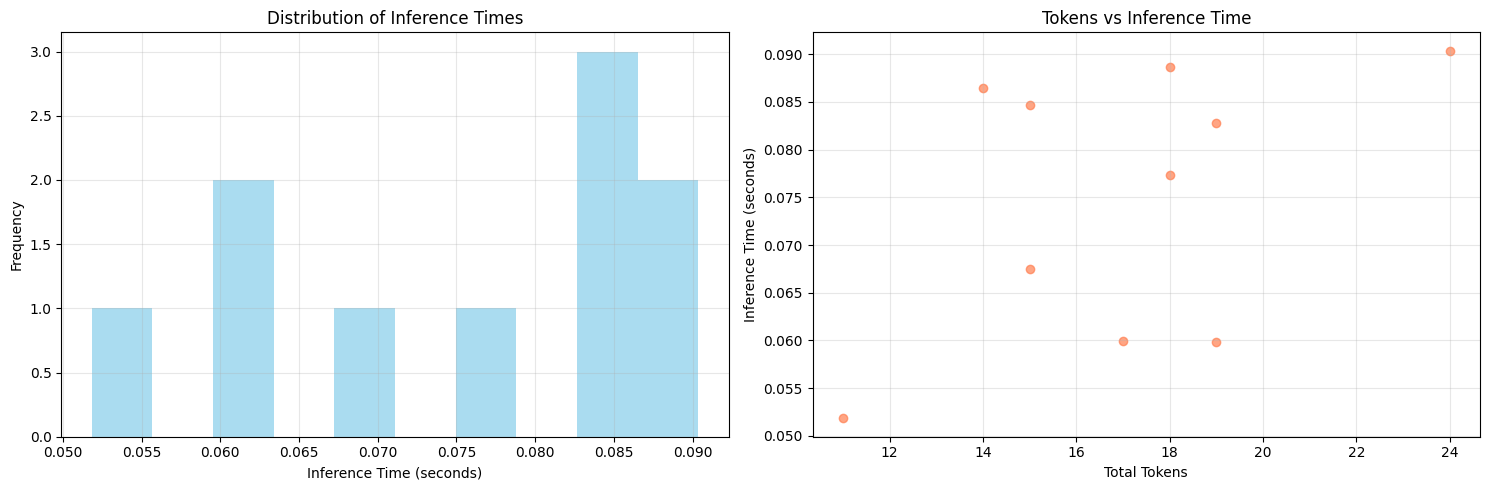

Average inference time: 0.07 seconds
Average tokens per request: 17
Total successful requests: 10
Failed requests: 0


In [13]:
# Performance analysis
import matplotlib.pyplot as plt

# Filter successful results
successful_results = df_results[df_results['response'] != '[FAILED]']

if len(successful_results) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Inference time distribution
    ax1.hist(successful_results['inference_time'], bins=10, alpha=0.7, color='skyblue')
    ax1.set_xlabel('Inference Time (seconds)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Inference Times')
    ax1.grid(True, alpha=0.3)
    
    # Token count vs inference time
    ax2.scatter(successful_results['tokens'], successful_results['inference_time'], 
               alpha=0.7, color='coral')
    ax2.set_xlabel('Total Tokens')
    ax2.set_ylabel('Inference Time (seconds)')
    ax2.set_title('Tokens vs Inference Time')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Average inference time: {successful_results['inference_time'].mean():.2f} seconds")
    print(f"Average tokens per request: {successful_results['tokens'].mean():.0f}")
    print(f"Total successful requests: {len(successful_results)}")
    print(f"Failed requests: {len(df_results) - len(successful_results)}")
else:
    print("No successful results to analyze.")